In [2]:
# import table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import itertools as it
import json
%matplotlib inline

from pm4py.objects.log.importer.xes import importer
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.discovery.inductive.variants.im_f import algorithm as im_f_algo
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

from dpv.util.converter import param_transform, downscale, merge
from dpv.variant_transformer import private_transform, public_transform
from dpv.variant_query import variant_query
from dpv.optimizer import release_optimizer
from dpv.data_utility import emd_utility, log_diff

In [2]:
# import xes event log (BPIC12 example)
log = importer.apply('BPI2012App.xes')

# process model from xes log
net1, im1, fm1 = im_f_algo.apply(log, parameters=None)

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [3]:
# compute summary statistics for single release queries

# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")

        # convert to p and k
        p, k = param_transform(eps, d)
        
        for i in range(10):

            # privatize variants            
            traces_orig, traces_priv = private_transform(log, p, k)

            # save results
            fp = open(f"variants_single_{eps}_{d}_{i}.json", "w")
            json.dump(traces_priv, fp)
            fp.close()

[+] eps: 2 delta: 0.5
[+] eps: 2 delta: 0.1
[+] eps: 2 delta: 0.05
[+] eps: 2 delta: 0.01
[+] eps: 2 delta: 0.001
[+] eps: 1 delta: 0.5
[+] eps: 1 delta: 0.1
[+] eps: 1 delta: 0.05
[+] eps: 1 delta: 0.01
[+] eps: 1 delta: 0.001
[+] eps: 0.1 delta: 0.5
[+] eps: 0.1 delta: 0.1
[+] eps: 0.1 delta: 0.05
[+] eps: 0.1 delta: 0.01
[+] eps: 0.1 delta: 0.001
[+] eps: 0.01 delta: 0.5
[+] eps: 0.01 delta: 0.1
[+] eps: 0.01 delta: 0.05
[+] eps: 0.01 delta: 0.01
[+] eps: 0.01 delta: 0.001
[+] eps: 0.001 delta: 0.5
[+] eps: 0.001 delta: 0.1
[+] eps: 0.001 delta: 0.05
[+] eps: 0.001 delta: 0.01
[+] eps: 0.001 delta: 0.001


In [5]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_single = np.zeros((len(eps_list), len(del_list)))
cost_single = np.zeros((len(eps_list), len(del_list)))

# compute metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        tmp_util = []
        tmp_cost = []
        for i in range(10):
        
            f = open(f'single/variants_single_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            tmp_util.append(emd_utility(log, priv_log))
            tmp_cost.append(log_diff(log, priv_log))
            f.close()
        
        util_single[m][n] = np.mean([x for x in tmp_util if x != 1])
        cost_single[m][n] = np.mean([x for x in tmp_cost if x != 130870])
        print(f'eps: {eps}, delta: {d}, util: {util_single[m][n]}, cost: {cost_single[m][n]}')
        
# save metrics
np.savetxt('single/util_single.txt', util_single)
np.savetxt('single/cost_single.txt', cost_single)

eps: 2, delta: 0.5, util: 0.998301765972025, cost: 24.3
eps: 2, delta: 0.1, util: 0.9979173678736, cost: 30.1
eps: 2, delta: 0.05, util: 0.9978740904015249, cost: 32.8
eps: 2, delta: 0.01, util: 0.99783846708655, cost: 47.5
eps: 2, delta: 0.001, util: 0.9978223095957249, cost: 62.6
eps: 1, delta: 0.5, util: 0.998088038603125, cost: 42.4
eps: 1, delta: 0.1, util: 0.998035879448725, cost: 66.2
eps: 1, delta: 0.05, util: 0.9981832635354249, cost: 85.7
eps: 1, delta: 0.01, util: 0.9977327337742, cost: 108.6
eps: 1, delta: 0.001, util: 0.9977196529570751, cost: 94.1
eps: 0.1, delta: 0.5, util: 0.99824177184775, cost: 47.5
eps: 0.1, delta: 0.1, util: 0.9978010629097748, cost: 109.8
eps: 0.1, delta: 0.05, util: 0.9975030155843501, cost: 256.7
eps: 0.1, delta: 0.01, util: 0.9968035873304497, cost: 501.2
eps: 0.1, delta: 0.001, util: 0.997124358063475, cost: 686.1
eps: 0.01, delta: 0.5, util: 0.998446605899575, cost: 63.1
eps: 0.01, delta: 0.1, util: 0.9975351913646499, cost: 207.8
eps: 0.01, d

In [3]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_single = np.zeros((len(eps_list), len(del_list)))
fit_single = np.zeros((len(eps_list), len(del_list)))
gen_single = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_single_avg = []
        fit_single_avg = []
        gen_single_avg = []

        for i in range(10):
            
            f = open(f'single/variants_single_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_single_avg.append(prec)
            fit_single_avg.append(fit['log_fitness'])
            gen_single_avg.append(gen)
            
            f.close()
        
        # save results
        prec_single[m][n] = np.mean(prec_single_avg)
        fit_single[m][n] = np.mean(fit_single_avg)
        gen_single[m][n] = np.mean(gen_single_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_single[m][n]}, fit: {fit_single[m][n]}, gen: {gen_single[m][n]}')

# save metrics
np.savetxt('single/prec_single.txt', prec_single)
np.savetxt('single/fit_single.txt', fit_single)
np.savetxt('single/gen_single.txt', gen_single)

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.4553587872134128, fit: 0.9950740337714983, gen: 0.6784621553809772


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.44516129032258067, fit: 0.994949494949495, gen: 0.6451307744489796


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.44516129032258067, fit: 0.994949494949495, gen: 0.6451307744489796


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.44516129032258067, fit: 0.994949494949495, gen: 0.6451307744489796


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.44516129032258067, fit: 0.994949494949495, gen: 0.6451307744489796


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.4553582405900136, fit: 0.9950737862321362, gen: 0.6784613341822961


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.44516129032258067, fit: 0.994949494949495, gen: 0.6451307744489796


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.465545621424632, fit: 0.9951946313291378, gen: 0.7100063732286903


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.44794621860807443, fit: 0.9950666980078744, gen: 0.66813444265602


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.4479665898617512, fit: 0.995064935064935, gen: 0.6681194102462724


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.4553588481536022, fit: 0.995075851756544, gen: 0.6784619747991177


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.4450387539676681, fit: 0.9949309852451214, gen: 0.6447200368925643


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.4456479731248251, fit: 0.9951175644125924, gen: 0.6525355414616906


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.4447543974322028, fit: 0.9948171103247361, gen: 0.6423876130719682


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.44465150299011036, fit: 0.9948370283761816, gen: 0.6427323498694355


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.44516129032258067, fit: 0.994949494949495, gen: 0.6451307744489796


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.44795038221397665, fit: 0.9951911459548981, gen: 0.6744280812520735


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.4449162176127556, fit: 0.9949124755407478, gen: 0.6443092993361488


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.44996748544457643, fit: 0.9949178564706515, gen: 0.664995033214205


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.4375797773133677, fit: 0.9974676533539361, gen: 0.6087320930612451


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.001, delta: 0.5, prec: 0.4553496463867382, fit: 0.9950734070189368, gen: 0.678459273964769


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

eps: 0.001, delta: 0.1, prec: 0.4557039406802826, fit: 0.9952141969563885, gen: 0.6838760075371366


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.001, delta: 0.05, prec: 0.44442607219310554, fit: 0.9948384367232534, gen: 0.6426663491104873


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.001, delta: 0.01, prec: 0.4447229316479758, fit: 0.9947375823886542, gen: 0.640833264959723


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

eps: 0.001, delta: 0.001, prec: 0.44269579512854723, fit: 0.9986827852159973, gen: 0.6147439708793202


In [269]:
# compute summary statistics for PINQ queries

# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
pruning = [[11, 11, 13, 13, 16],[19, 24, 24, 26, 27],[40, 110, 140, 170, 205],[50, 180, 310, 770, 1350],[50, 200, 350, 1300, 6000]]

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")
        
        for i in range(10):
            
            # privatize variant frequencies
            l = 0
            while l < 16 or l > 18:
                query_vars = variant_query(log, eps/8, cutoff=8, prune=pruning[m][n], delta=d/8)
                l = len(query_vars)
                
            # save results
            fp = open(f"variants_benchmark_{eps}_{d}_{i}.json", "w")
            json.dump(query_vars, fp)
            fp.close()

[+] eps: 2 delta: 0.5
[+] eps: 2 delta: 0.1
[+] eps: 2 delta: 0.05
[+] eps: 2 delta: 0.01
[+] eps: 2 delta: 0.001
[+] eps: 1 delta: 0.5
[+] eps: 1 delta: 0.1
[+] eps: 1 delta: 0.05
[+] eps: 1 delta: 0.01
[+] eps: 1 delta: 0.001
[+] eps: 0.1 delta: 0.5
[+] eps: 0.1 delta: 0.1
[+] eps: 0.1 delta: 0.05
[+] eps: 0.1 delta: 0.01
[+] eps: 0.1 delta: 0.001
[+] eps: 0.01 delta: 0.5
[+] eps: 0.01 delta: 0.1
[+] eps: 0.01 delta: 0.05
[+] eps: 0.01 delta: 0.01
[+] eps: 0.01 delta: 0.001
[+] eps: 0.001 delta: 0.5
[+] eps: 0.001 delta: 0.1
[+] eps: 0.001 delta: 0.05
[+] eps: 0.001 delta: 0.01
[+] eps: 0.001 delta: 0.001


In [6]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_bench = np.zeros((len(eps_list), len(del_list)))
cost_bench = np.zeros((len(eps_list), len(del_list)))

# compute metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        tmp_util = []
        tmp_cost = []
        for i in range(10):
        
            f = open(f'benchmark/variants_benchmark_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            tmp_util.append(emd_utility(log, priv_log))
            tmp_cost.append(log_diff(log, priv_log))
            f.close()
        
        util_bench[m][n] = np.mean([x for x in tmp_util if x != 1])
        cost_bench[m][n] = np.mean([x for x in tmp_cost if x != 130870])
        print(f'eps: {eps}, delta: {d}, util: {util_bench[m][n]}, cost: {cost_bench[m][n]}')
        
# save metrics
np.savetxt('benchmark/util_bench.txt', util_bench)
np.savetxt('benchmark/cost_bench.txt', cost_bench)

eps: 2, delta: 0.5, util: 0.9507834956304123, cost: 659.6
eps: 2, delta: 0.1, util: 0.9604695581241458, cost: 622.3
eps: 2, delta: 0.05, util: 0.9589131741844875, cost: 548.5
eps: 2, delta: 0.01, util: 0.958635899592125, cost: 615.5
eps: 2, delta: 0.001, util: 0.9579827153434876, cost: 633.8
eps: 1, delta: 0.5, util: 0.9582193040402958, cost: 845.4
eps: 1, delta: 0.1, util: 0.9592299229236249, cost: 1010.3
eps: 1, delta: 0.05, util: 0.9654646424673998, cost: 1369.9
eps: 1, delta: 0.01, util: 0.9651613949897924, cost: 1422.7
eps: 1, delta: 0.001, util: 0.9611820699914497, cost: 954.2
eps: 0.1, delta: 0.5, util: 0.9676388292081249, cost: 2344.7
eps: 0.1, delta: 0.1, util: 0.9504223816125499, cost: 10627.7
eps: 0.1, delta: 0.05, util: 0.9523937973441541, cost: 11093.9
eps: 0.1, delta: 0.01, util: 0.9340988252498249, cost: 22897.1
eps: 0.1, delta: 0.001, util: 0.934349575766, cost: 27107.4
eps: 0.01, delta: 0.5, util: 0.955678488415425, cost: 2668.6
eps: 0.01, delta: 0.1, util: 0.939369363

In [4]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_bench = np.zeros((len(eps_list), len(del_list)))
fit_bench = np.zeros((len(eps_list), len(del_list)))
gen_bench = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_bench_avg = []
        fit_bench_avg = []
        gen_bench_avg = []

        for i in range(10):
            
            f = open(f'benchmark/variants_benchmark_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_bench_avg.append(prec)
            fit_bench_avg.append(fit['log_fitness'])
            gen_bench_avg.append(gen)
            
            f.close()
        
        # save results
        prec_bench[m][n] = np.mean(prec_bench_avg)
        fit_bench[m][n] = np.mean(fit_bench_avg)
        gen_bench[m][n] = np.mean(gen_bench_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_bench[m][n]}, fit: {fit_bench[m][n]}, gen: {gen_bench[m][n]}')

# save metrics
np.savetxt('benchmark/prec_bench.txt', prec_bench)
np.savetxt('benchmark/fit_bench.txt', fit_bench)
np.savetxt('benchmark/gen_bench.txt', gen_bench)

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.4843460549566738, fit: 0.9961240943985461, gen: 0.8883512535316532


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.47681206798034925, fit: 0.9959050570614203, gen: 0.8942602195630395


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.4823996858558296, fit: 0.9960948608512823, gen: 0.886728443434613


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.4788022195704217, fit: 0.9959747664256289, gen: 0.8876289249488083


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.47652954609531256, fit: 0.9961710272977727, gen: 0.8545689014419814


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.4807867730430903, fit: 0.9957918174468157, gen: 0.8686907199855071


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.48323328844940716, fit: 0.9952985752532101, gen: 0.8905925495906664


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.48836341895024643, fit: 0.9951585687482691, gen: 0.8833814891434818


replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.4805528632583325, fit: 0.9947846984960478, gen: 0.8888793907200899


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.4828671435889711, fit: 0.994706859164409, gen: 0.8835937301698129


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.4866766747659952, fit: 0.9933796655084901, gen: 0.8871189044625399


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.4218937490563325, fit: 0.9860184147872321, gen: 0.577557460586221


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.41749596605761036, fit: 0.9827758705410428, gen: 0.4717705312846485


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.4768080235559933, fit: 0.9638876875015333, gen: 0.6818053233469247


replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.45234369930193363, fit: 0.9573411038004955, gen: 0.6730572140775692


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.4680439757073179, fit: 0.992805449607237, gen: 0.7876379701632077


replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.4521636720299379, fit: 0.9690549059159222, gen: 0.6298546864235687


replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.44782400832723007, fit: 0.9253599922484799, gen: 0.6298298588917989


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.42293564875919626, fit: 0.8440142858296908, gen: 0.45814949218024675


replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.3778376883396419, fit: 0.7595134188445796, gen: 0.4556613267292831


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

eps: 0.001, delta: 0.5, prec: 0.4661886292015147, fit: 0.9927187978429888, gen: 0.7725993344267741


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.001, delta: 0.1, prec: 0.40370724607579467, fit: 0.9727288542855421, gen: 0.4582699363616724


replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.001, delta: 0.05, prec: 0.44939109891355067, fit: 0.9272195711830907, gen: 0.5590927910341703


replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/19 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

eps: 0.001, delta: 0.01, prec: 0.454517431478341, fit: 0.7786222045216559, gen: 0.5470611055152087


replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 0.001, delta: 0.001, prec: 0.4008179303175098, fit: 0.5892318115170448, gen: 0.46411603430170045


In [4]:
# compute summary statistics for multi release queries

# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_multi = np.zeros((len(eps_list), len(del_list)))
cost_multi = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")

        # privatize variants
        util_multi[m][n], cost_multi[m][n], _, _, _, data = release_optimizer(log, eps, d, domain=[2,10], clean=[1.0, 130870], data=True, debug=False)
        print(f"[-] Avg Util: {util_multi[m][n]}")
        print(f"[-] Avg Cost: {cost_multi[m][n]}")
        
        # save logs
        for i, ret in enumerate(data):
            fp = open(f"variants_multi_{eps}_{d}_{i}.json", "w")
            json.dump(ret, fp)
            fp.close()
        
# save metrics
np.savetxt('util_multi.txt', util_multi)
np.savetxt('cost_multi.txt', cost_multi)

[+] eps: 2 delta: 0.5
[-] Avg Util: 0.9469468481964249
[-] Avg Cost: 68.2
[+] eps: 2 delta: 0.1
[-] Avg Util: 0.9502639995494502
[-] Avg Cost: 83.8
[+] eps: 2 delta: 0.05
[-] Avg Util: 0.9507452818816
[-] Avg Cost: 109.0
[+] eps: 2 delta: 0.01
[-] Avg Util: 0.951224557581325
[-] Avg Cost: 129.8
[+] eps: 2 delta: 0.001
[-] Avg Util: 0.9512096859035498
[-] Avg Cost: 159.9
[+] eps: 1 delta: 0.5
[-] Avg Util: 0.9468442461600999
[-] Avg Cost: 61.9
[+] eps: 1 delta: 0.1
[-] Avg Util: 0.9502435770645249
[-] Avg Cost: 93.6
[+] eps: 1 delta: 0.05
[-] Avg Util: 0.9507866377223501
[-] Avg Cost: 113.1
[+] eps: 1 delta: 0.01
[-] Avg Util: 0.9518227038750251
[-] Avg Cost: 467.1
[+] eps: 1 delta: 0.001
[-] Avg Util: 0.9601956151888749
[-] Avg Cost: 727.7
[+] eps: 0.1 delta: 0.5
[-] Avg Util: 0.946437181577575
[-] Avg Cost: 53.7
[+] eps: 0.1 delta: 0.1
[-] Avg Util: 0.9502060740785501
[-] Avg Cost: 227.3
[+] eps: 0.1 delta: 0.05
[-] Avg Util: 0.9540396822219248
[-] Avg Cost: 734.6
[+] eps: 0.1 delta: 

In [5]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_multi = np.zeros((len(eps_list), len(del_list)))
fit_multi = np.zeros((len(eps_list), len(del_list)))
gen_multi = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_multi_avg = []
        fit_multi_avg = []
        gen_multi_avg = []

        for i in range(10):
            
            f = open(f'multi/variants_multi_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_multi_avg.append(prec)
            fit_multi_avg.append(fit['log_fitness'])
            gen_multi_avg.append(gen)
            
            f.close()
        
        # save results
        prec_multi[m][n] = np.mean(prec_multi_avg)
        fit_multi[m][n] = np.mean(fit_multi_avg)
        gen_multi[m][n] = np.mean(gen_multi_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_multi[m][n]}, fit: {fit_multi[m][n]}, gen: {gen_multi[m][n]}')

# save metrics
np.savetxt('multi/prec_multi.txt', prec_multi)
np.savetxt('multi/fit_multi.txt', fit_multi)
np.savetxt('multi/gen_multi.txt', gen_multi)

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.4717525786516562, fit: 0.9964432441326798, gen: 0.8300317762997361


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.45485238493758845, fit: 0.9964767509107644, gen: 0.8040475516946696


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.45254608789987677, fit: 0.9965359689995074, gen: 0.7883934234851678


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.456883572352479, fit: 0.9964361965431389, gen: 0.8119438693412728


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.4526313404120833, fit: 0.9965141335465402, gen: 0.7958043292173558


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.4623223503364402, fit: 0.9964769155358326, gen: 0.8138088839233693


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.45485238493758845, fit: 0.9964767509107644, gen: 0.8040475516946696


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.4544100110162471, fit: 0.9965144757372444, gen: 0.7965325984116534


replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.4684113677247327, fit: 0.9963831857682072, gen: 0.8312801840027504


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.454457957716477, fit: 0.996452986151024, gen: 0.8029470067863365


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.452822146782858, fit: 0.9965180237106578, gen: 0.796187166976682


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.4565121122042363, fit: 0.9964884219346924, gen: 0.8076039724058452


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.4806651243570269, fit: 0.9963152701973904, gen: 0.8640515133659286


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.4664642060794065, fit: 0.9956877494910745, gen: 0.7962427859328965


replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.45265845688977374, fit: 0.9965066476441514, gen: 0.7996878773384564


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.48518547415458235, fit: 0.9963268589196996, gen: 0.8628350226384196


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.49002731918424774, fit: 0.9962515399490919, gen: 0.870763357554468


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.4663485578673905, fit: 0.9964222014467096, gen: 0.8243118024749105


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.46490780224537354, fit: 0.9965499379426076, gen: 0.7838542416987604


replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.4089464530630738, fit: 0.9984791092745638, gen: 0.45147575614412927


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

eps: 0.001, delta: 0.5, prec: 0.48296247920281754, fit: 0.996388971261057, gen: 0.8467404838699284


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

eps: 0.001, delta: 0.1, prec: 0.45213233049674273, fit: 0.9965071400512668, gen: 0.7869798354974972


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

eps: 0.001, delta: 0.05, prec: 0.47901190279023426, fit: 0.995872405900157, gen: 0.8378946690137781


replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

eps: 0.001, delta: 0.01, prec: 0.46441368093643254, fit: 0.994793914854488, gen: 0.7327555127791432


replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

eps: 0.001, delta: 0.001, prec: 0.39418642800449744, fit: 0.9927930515916694, gen: 0.42008968294991716


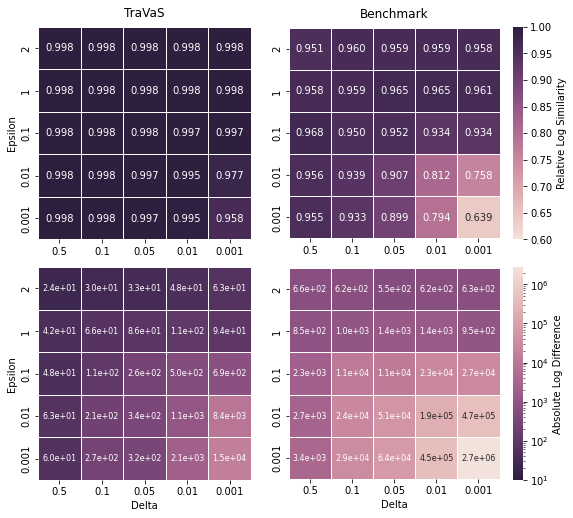

In [3]:
# load final data
util_single = np.loadtxt('single/util_single.txt')
util_multi = np.loadtxt('multi/util_multi.txt')
util_bench = np.loadtxt('benchmark/util_bench.txt')

cost_single = np.loadtxt('single/cost_single.txt')
cost_multi = np.loadtxt('multi/cost_multi.txt')
cost_bench = np.loadtxt('benchmark/cost_bench.txt')

util_best = np.maximum(util_single, util_multi)
cost_best = np.minimum(cost_single, cost_multi)

# create plots
f, ax = plt.subplots(2, 2, figsize=(8.3, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap_r = sns.cubehelix_palette(as_cmap=True, light=.9, reverse=True)
cmap.set_bad('grey', 1.)
cmap_r.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(util_best, ax=ax[0,0], vmin=0.6, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(util_bench, ax=ax[0,1], vmin=0.6, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Relative Log Similarity'})
ax[1,0] = sns.heatmap(cost_best, ax=ax[1,0], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e1, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, annot_kws={"fontsize":8})
ax[1,1] = sns.heatmap(cost_bench, ax=ax[1,1], cmap=cmap_r, norm=LogNorm(vmin=1e1, vmax=np.nanmax(cost_bench)), square=True, annot=True, fmt='.1e', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Absolute Log Difference'}, annot_kws={"fontsize":8})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
f.tight_layout()
plt.savefig("BPIC12_1.pdf")

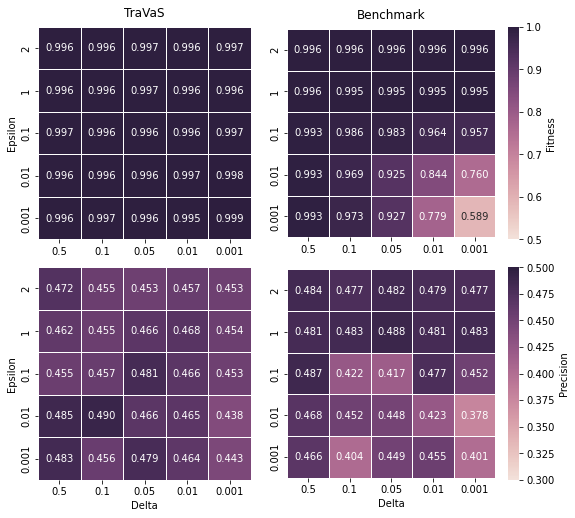

In [4]:
# load final data
prec_single = np.loadtxt('single/prec_single.txt')
prec_multi = np.loadtxt('multi/prec_multi.txt')
prec_bench = np.loadtxt('benchmark/prec_bench.txt')
prec_best = np.maximum(prec_single, prec_multi)

fit_single = np.loadtxt('single/fit_single.txt')
fit_multi = np.loadtxt('multi/fit_multi.txt')
fit_bench = np.loadtxt('benchmark/fit_bench.txt')
fit_best = np.maximum(fit_single, fit_multi)

gen_single = np.loadtxt('single/gen_single.txt')
gen_multi = np.loadtxt('multi/gen_multi.txt')
gen_bench = np.loadtxt('benchmark/gen_bench.txt')
gen_best = np.maximum(gen_single, gen_multi)

# create plots
f, ax = plt.subplots(2, 2, figsize=(8.3, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(fit_best, ax=ax[0,0], vmin=0.5, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(fit_bench, ax=ax[0,1], vmin=0.5, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Fitness'})
ax[1,0] = sns.heatmap(prec_best, ax=ax[1,0], cmap=cmap, square=True, vmin=0.3, vmax=0.5, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[1,1] = sns.heatmap(prec_bench, ax=ax[1,1], cmap=cmap, vmin=0.3, vmax=0.5, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Precision'})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
f.tight_layout()
plt.savefig("BPIC12_2.pdf")